<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
class PolicyNetwork(nn.Block):
  def __init__(self,num_actions):
    super(PolicyNetwork,self).__init__()
    self.linear1 = nn.Dense(128)
    self.linear2 = nn.Dense(num_actions)
  def forward(self,x):
    x = nd.array(x)
    x = nd.relu(self.linear1(x))
    x = nd.softmax(self.linear2(x))
    return x
  def get_action(self,x):
    probs = self.forward(x)
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    return action,log_prob

In [3]:
#test
p = PolicyNetwork(2)
p.initialize(init=init.Xavier())
s1 = np.array([1,2,3,4])
s2 = np.array([2,3,4,5])
batch_state = np.stack([s1,s2])
print('===============')
print(p.get_action([s1]))
print('===============')
print(p.get_action(batch_state))

(
[1]
<NDArray 1 @cpu(0)>, 
[-0.44218192]
<NDArray 1 @cpu(0)>)
(
[1 1]
<NDArray 2 @cpu(0)>, 
[-0.44218192 -0.36352086]
<NDArray 2 @cpu(0)>)


# main loop

0 8
20 19
40 16
60 103
80 29
100 59
120 66
140 135
160 65
180 52
200 138
220 159
240 60
260 159
280 142
300 199
320 179
340 199
360 199
380 199
400 199
420 199
440 199
460 199
480 199
500 199
520 199
540 199
560 199
580 199
600 136
620 142
640 180
660 127
680 185
700 166
720 157
740 199
760 199
780 199
800 199
820 199
840 199
860 199
880 199
900 199
920 186
940 199
960 186
980 161


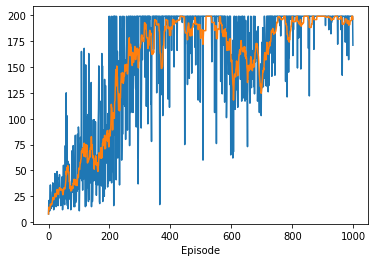

In [4]:
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.action_space.n)
policy_net.initialize(init=init.Xavier())
trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':0.001})

max_episode_num = 1000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []

for episode in range(max_episode_num):
  state = env.reset()
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      action, log_prob = policy_net.get_action(state)
      state, reward, done, _ = env.step(action.asnumpy()[0])
      log_probs.append(log_prob)
      rewards.append(reward)
      if done:
        break
    
    # logging
    numsteps.append(t)
    avg_numsteps.append(np.mean(numsteps[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() + np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(t)
  
  # print info
  if episode % 20 == 0:
    print(episode,t)

plt.plot(numsteps)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.show()